# OpenBB terminal import

pip install openbb

In [8]:
import openbb_terminal
from openbb_terminal.sdk import openbb

# Libraries

In [9]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))
import plotly.graph_objects as go

from yahooquery import Screener
from yahoo_fin import stock_info as si
import datetime 
import pandas as pd
from datetime import datetime
import math
import requests
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use("seaborn-v0_8")

import telebot as tb
from bob_telegram_tools.bot import TelegramBot

BOT_TOKEN = "ENTER BOT TOKEN" 
bot = tb.TeleBot(BOT_TOKEN)

user_id = int('ENTER USER TOKEN') 
bot2 = TelegramBot(BOT_TOKEN, user_id)

# Keys  

Here you specify your unique keys

In [10]:
## binance
# openbb.keys.binance(key = 'ENTER KEY', secret = 'ENTER SECRET KEY', persist = True)

# openbb.keys.mykeys(show = True)
# help(openbb.keys)

# Get the inital token or stock data

In [11]:
# List of top 250 tokens formula
def list_tokens():
    s = Screener()
    data = s.get_screeners('all_cryptocurrencies_us', count=250)

    # data is in the quotes key
    dicts = data['all_cryptocurrencies_us']['quotes']
    symbols = [d['symbol'] for d in dicts]
    tokens =  [x[:-4].lower() for x in symbols]
    tokens = tokens +[] # To add tokens (check before), put in lowercase
    return tokens

# List of 11650 stock tickers
def list_stocks():
    # gather stock symbols from major US exchanges
    df1 = pd.DataFrame( si.tickers_sp500() )
    df2 = pd.DataFrame( si.tickers_nasdaq() )
    df3 = pd.DataFrame( si.tickers_dow() )
    df4 = pd.DataFrame( si.tickers_other() )

    # convert DataFrame to list, then to sets
    sym1 = set( symbol for symbol in df1[0].values.tolist() )
    sym2 = set( symbol for symbol in df2[0].values.tolist() )
    sym3 = set( symbol for symbol in df3[0].values.tolist() )
    sym4 = set( symbol for symbol in df4[0].values.tolist() )
    
    # join the 4 sets into one. Because it's a set, there will be no duplicate symbols
    symbols = list(set.union( sym1, sym2, sym3, sym4))[1:]
    symbols = [x.lower() for x in symbols]

    return symbols

# Gets current price for ethier the token or stock (limited to 250 tokens, 11650 stocks)
def get_current_price(ticker):
    ticker = ticker.lower()
    if ticker in list_tokens():
        key = "https://api.binance.us/api/v3/ticker/price?symbol=" + ticker.upper() + "USD"
        price = requests.get(key).json()['price']
        return price
    if ticker in list_stocks():
        price = str(si.get_live_price(ticker))
        return price

# Gathers data for either the token or stock being called (ticker) (limited to 250 tokens, 11650 stocks)
def get_asset_data(ticker):
    
    if ticker in list_tokens():
        df = openbb.crypto.load(ticker, source = 'YahooFinance', exchange = 'binance', start_date = '1990-01-01')
    if ticker in list_stocks():
        df = openbb.stocks.load( symbol = ticker, start_date = '1990-01-01', end_date = datetime.today().strftime('%Y-%m-%d'), interval = 1440, prepost = False, source = 'YahooFinance',  weekly = False, monthly = False)
    
    df.columns.name = ticker.upper()
    df_send = df.copy()

    df["Return_from0"] = df.Close.div(df.iloc[0]["Close"])
    df["TypicalPrice"] = (df.Close + df.High + df.Low) / 3
    df["SMA20"] = df.Close.rolling(20).mean()
    df["STD"] = df.Close.rolling(20).std()
    df["Perc_change"] =  df.Close.pct_change().mul(100)


    df["SMA20_up"] = df.SMA20  + (2 * df.STD) 
    df["SMA20_down"] = df.SMA20  - (2 * df.STD)


    return df, df_send

# Class that creates plots

Plots are:
1. Trend line since first record in openBB
2. The return currently if you invested 1 dollar in the last 50 days
3. The return currently if you invested 1 dollar a year ago
4. Fibonacci Retracement (Not really useful unless you are more specific with dates)
5. Bollinger Bangs 
6. Return (Percent Change) over the the last year

Feel free to add more

In [12]:
background_color = "black"

class GetDataAndCreatePlots:
    def __init__(self , ticker, data):
        self.ticker = ticker
        self.data = data
        
# Trend line since openbb started recording
    def plot_trendline(self):
        ticker = self.ticker
        data = self.data
        
        df = data[0]#.iloc[-50:]
        # Create
        fig, ax = plt.subplots()
        ax.plot(df.Close, color='blue') # Solid line
        fig.set_facecolor(background_color)

        plt.xticks(rotation=30, ha='right', color= "white")

        plt.title(ticker.upper() +" - Trend Line since: " + ((df.index.tolist())[0]).strftime("%Y-%m-%d"), color = "white")
        plt.ylabel("Price", color = "white")
        plt.xlabel("Date", color = "white")
        plt.yticks(ha='left', color= "white")
        plt.legend(loc="upper left")

        plt.close()
        return fig

# Plot Return from $1 invested last 50 entrees
    def plot_return_from_1_date(self):
        ticker = self.ticker
        data = self.data
        
        df = data[0].iloc[-50:]
        df["Return_from0"] = df.Close.div(df.iloc[0]["Close"])
        # Create
        fig, ax = plt.subplots()
        ax.plot(df.Return_from0, color='black') # Solid line
        fig.set_facecolor(background_color)

        plt.xticks(rotation=30, ha='right', color= "white")

        plt.title(ticker.upper() +" - Return from $1 dollar since: " + ((df.index.tolist())[0]).strftime("%Y-%m-%d"), color = "white")
        plt.ylabel("Price", color = "white")
        plt.xlabel("Date", color = "white")
        plt.yticks(ha='left', color= "white")
        plt.legend(loc="upper left")

        plt.close()
        return fig
    
# Plot Return from $1 invested over last year
    def plot_return_from_1_ytd(self):
        ticker = self.ticker
        data = self.data
        
        df = data[0].loc[pd.Timestamp(str((pd.Timestamp("today").year) - 1) +"-" +str((pd.Timestamp("today").normalize().month)) +"-" +str((pd.Timestamp("today").normalize().day))).strftime('%Y-%m-%d'):]
        df["Return_from0"] = df.Close.div(df.iloc[0]["Close"])
        # Create
        fig, ax = plt.subplots()
        ax.plot(df.Return_from0, color='black') # Solid line
        fig.set_facecolor(background_color)

        plt.xticks(rotation=30, ha='right', color= "white")

        plt.title(ticker.upper() +" - Return from $1 dollar since: " + ((df.index.tolist())[0]).strftime("%Y-%m-%d"), color = "white")
        plt.ylabel("Price", color = "white")
        plt.xlabel("Date", color = "white")
        plt.yticks(ha='left', color= "white")
        plt.legend(loc="upper left")

        plt.close()
        return fig


# Fib Plot
    def plot_fibretrace(self):
        ticker = self.ticker
        data =   self.data
        
        df = data[0].iloc[-30:]

        mean = df.Close.mean()
        std = df.Close.std()

        price_max = df.Close.max()
        price_min = df.Close.min()
        diff = price_max - price_min

        level1 = price_max - 0.236 * diff
        level2 = price_max - 0.382 * diff
        level3 = price_max - 0.618 * diff
        # Create
        fig, ax = plt.subplots()
        fig.set_facecolor(background_color)
            

        ax.axhspan(level1, price_min, alpha=0.4, color='darkred', label = "100%")
        ax.axhspan(level3, level2, alpha=0.5, color='pink', label = "61.8%")
        ax.axhspan(level2,level1, alpha=0.5, color='green', label = "38.2%")
        ax.axhspan(price_max, level3, alpha=0.5, color='powderblue', label = "23.6%")

        #define width of candlestick elements
        width = 1
        width2 = .3

        #define up and down df1
        up = df[df.Close>=df.Open]
        down = df[df.Close<df.Open]

        #define colors to use
        col1 = 'green'
        col2 = 'red'

        #plot up df1
        plt.bar(up.index,up.Close-up.Open,width,bottom=up.Open,color=col1)
        plt.bar(up.index,up.High-up.Close,width2,bottom=up.Close,color=col1)
        plt.bar(up.index,up.Low-up.Open,width2,bottom=up.Open,color=col1)

        #plot down df1
        plt.bar(down.index,down.Close-down.Open,width,bottom=down.Open,color=col2)
        plt.bar(down.index,down.High-down.Open,width2,bottom=down.Open,color=col2)
        plt.bar(down.index,down.Low-down.Close,width2,bottom=down.Close,color=col2)

        plt.ylabel("Price", color = "white")
        plt.xlabel("Date", color = "white")
        plt.xticks(rotation=30, ha='right', color= "white")
        plt.yticks(ha='left', color= "white")
        plt.legend(loc=2)
        plt.title(ticker.upper() + " - Fib Retrace since: "+ ((df.index.tolist())[0]).strftime("%Y-%m-%d"), color = "white")

        high_constraint =(df.High.max() * df.High.max())/ (df.High.max() - (df.High.max()* .01))
        low_constraint = (df.Low.min() * df.Low.min())/ (df.Low.min() + (df.Low.min()* .01))

        ax.set_ylim([low_constraint, high_constraint])

        plt.close()
        return fig

    def plot_bollbands(self):
        ticker = self.ticker
        data =   self.data
        
        df = data[0].iloc[-50:]
        #create figure
        fig = plt.figure()
        fig.set_facecolor(background_color)

        df.SMA20.plot()
        df.SMA20_up.plot()
        df.SMA20_down.plot( color="blue")

        #rotate x-axis tick labels
        plt.xticks(rotation=30, ha='right', color= "white")

        plt.title(ticker.upper() +" - Boll Bands since: " + ((df.index.tolist())[0]).strftime("%Y-%m-%d"), color = "white")
        plt.ylabel("Price", color = "white")
        plt.xlabel("Date", color = "white")
        plt.yticks(ha='left', color= "white")
        plt.legend(loc="upper left")
        
        #define width of candlestick elements
        width = 1
        width2 = .3

        #define up and down df1
        up = df[df.Close>=df.Open]
        down = df[df.Close<df.Open]

        #define colors to use
        col1 = 'green'
        col2 = 'red'

        #plot up df1
        plt.bar(up.index,up.Close-up.Open,width,bottom=up.Open,color=col1)
        plt.bar(up.index,up.High-up.Close,width2,bottom=up.Close,color=col1)
        plt.bar(up.index,up.Low-up.Open,width2,bottom=up.Open,color=col1)

        #plot down df1
        plt.bar(down.index,down.Close-down.Open,width,bottom=down.Open,color=col2)
        plt.bar(down.index,down.High-down.Open,width2,bottom=down.Open,color=col2)
        plt.bar(down.index,down.Low-down.Close,width2,bottom=down.Close,color=col2)
        plt.close()
        return fig
    
    def return_plot(self):
        ticker = self.ticker
        data = self.data
        
        df = data[0].loc[pd.Timestamp(str((pd.Timestamp("today").year) - 1) +"-" +str((pd.Timestamp("today").normalize().month)) +"-" +str((pd.Timestamp("today").normalize().day))).strftime('%Y-%m-%d'):]

        # Create
        fig, ax = plt.subplots()
        ax.plot(df.Perc_change, color='black') # Solid line
        fig.set_facecolor(background_color)

        plt.xticks(rotation=30, ha='right', color= "white")

        plt.title(ticker.upper() +" - Return since: "+ ((df.index.tolist())[0]).strftime("%Y-%m-%d") , color = "white")
        plt.ylabel("Price", color = "white")
        plt.xlabel("Date", color = "white")
        plt.yticks(ha='left', color= "white")
        plt.legend(loc="upper left")

        plt.close()
        return fig
    
    def return_norm_plot(self):
        ticker = self.ticker
        data = self.data
        
        df = data[0].loc[pd.Timestamp(str((pd.Timestamp("today").year) - 1) +"-" +str((pd.Timestamp("today").normalize().month)) +"-" +str((pd.Timestamp("today").normalize().day))).strftime('%Y-%m-%d'):]

#         # Create
        fig, ax = plt.subplots()
        ax.hist(df.Perc_change, bins=20)
        fig.set_facecolor(background_color)
        
        plt.title(ticker.upper() +" - Return Distribution since: "+ ((df.index.tolist())[0]).strftime("%Y-%m-%d") , color = "white")
        plt.ylabel("Price", color = "white")
        plt.xlabel("Date", color = "white")
        plt.yticks(ha='left', color= "white")
        plt.legend(loc="upper left")

        plt.close()
        return fig

        
# Main function to call        
def main( ticker , data):
    
    trend_plot = GetDataAndCreatePlots( ticker , data).plot_trendline()
    date_plot  = GetDataAndCreatePlots( ticker , data).plot_return_from_1_date()
    ytd_plot   = GetDataAndCreatePlots( ticker , data).plot_return_from_1_ytd()
    fib_plot   = GetDataAndCreatePlots( ticker , data).plot_fibretrace()
    boll_plot  = GetDataAndCreatePlots( ticker , data).plot_bollbands()
    return_plot = GetDataAndCreatePlots( ticker , data).return_plot()
    return_norm_plot = GetDataAndCreatePlots( ticker , data).return_norm_plot()
    
    return data, trend_plot, date_plot, ytd_plot, fib_plot, boll_plot, return_plot, return_norm_plot

# To just run report locally and not return in Telegram use script below

XRP,Open,High,Low,Close,Adj Close,Volume,Return_from0,TypicalPrice,SMA20,STD,Perc_change,SMA20_up,SMA20_down
date,,,,,,,,,,,,,
2017-11-09,0.217911,0.221791,0.214866,0.217488,0.217488,147916992,1.000000,0.218048,NaN,NaN,NaN,NaN,NaN
2017-11-10,0.218256,0.219068,0.205260,0.206483,0.206483,141032992,0.949400,0.210270,NaN,NaN,-5.060049,NaN,NaN
2017-11-11,0.205948,0.214456,0.205459,0.210430,0.210430,134503008,0.967548,0.210115,NaN,NaN,1.911532,NaN,NaN
2017-11-12,0.210214,0.210214,0.195389,0.197339,0.197339,251175008,0.907356,0.200981,NaN,NaN,-6.221070,NaN,NaN
2017-11-13,0.197472,0.204081,0.197456,0.203442,0.203442,132567000,0.935417,0.201660,NaN,NaN,3.092652,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-23,0.422451,0.454085,0.415477,0.444850,0.444850,2161421825,2.045400,0.438137,0.384686,0.028229,5.294928,0.441144,0.328227
2023-03-24,0.444856,0.444874,0.418034,0.425902,0.425902,1314887049,1.958278,0.429603,0.387290,0.029545,-4.259411,0.446381,0.328199
2023-03-25,0.425911,0.463645,0.424218,0.444716,0.444716,1832767576,2.044784,0.444193,0.391166,0.031772,4.417447,0.454709,0.327623


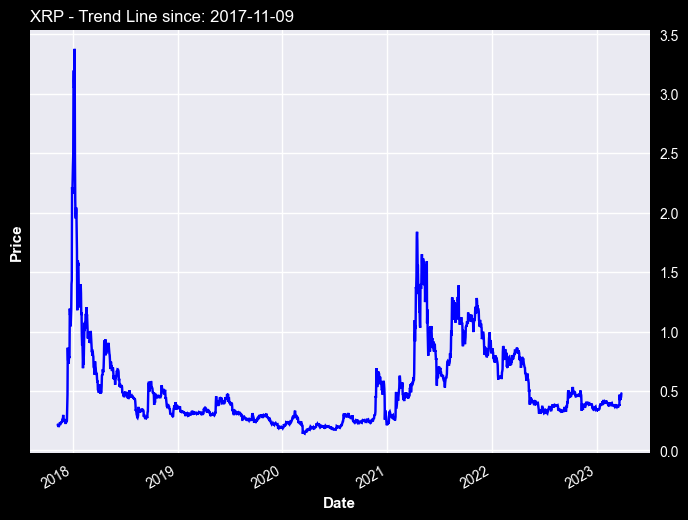

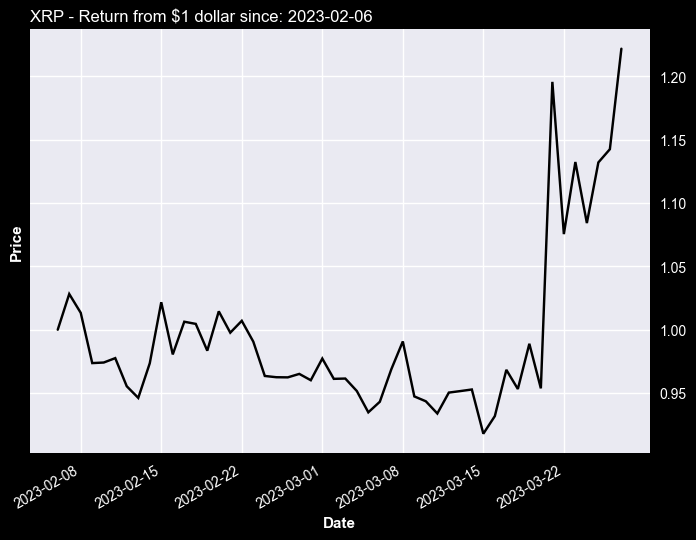

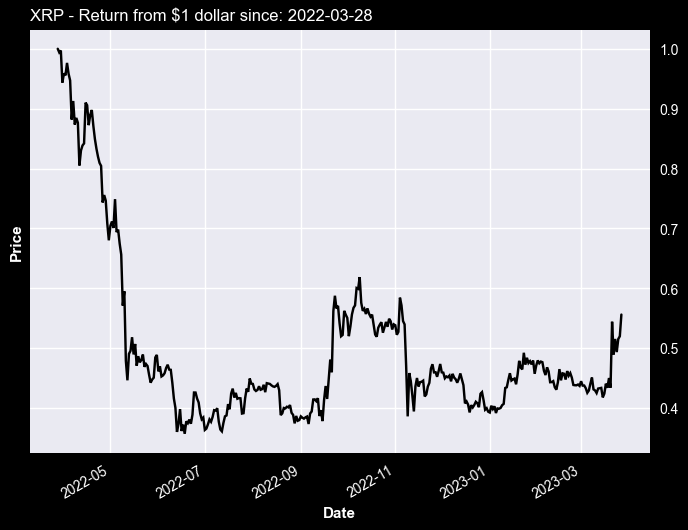

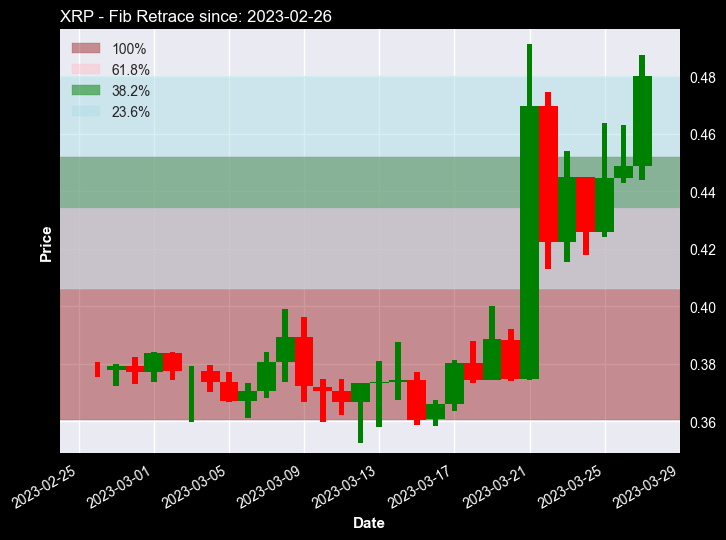

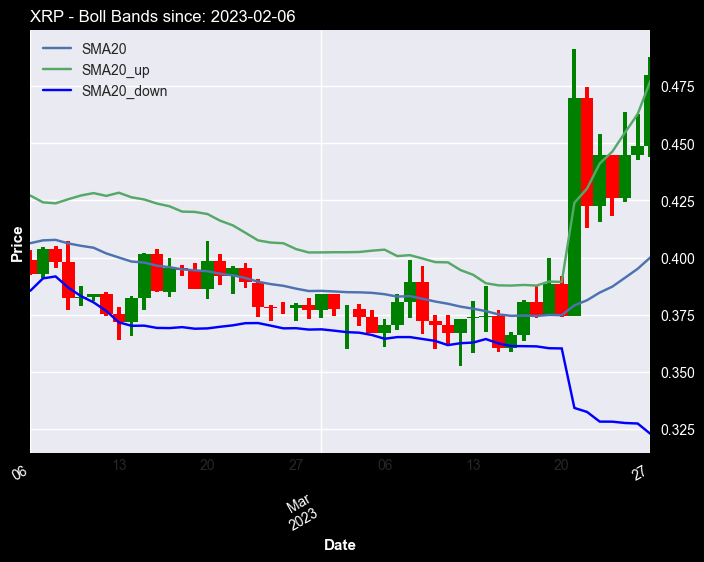

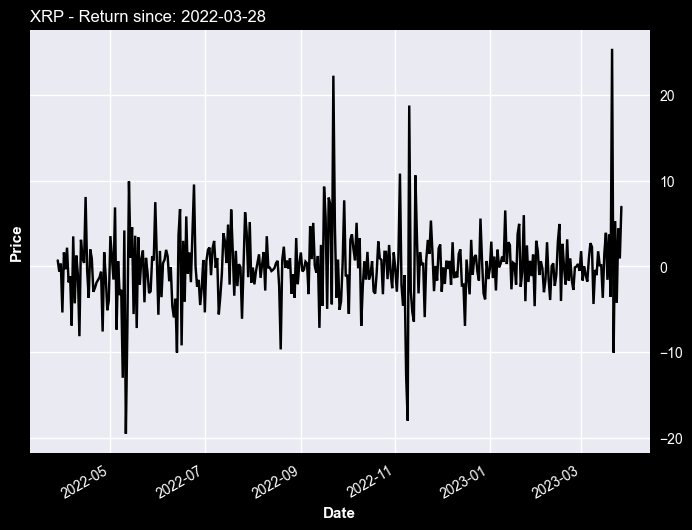

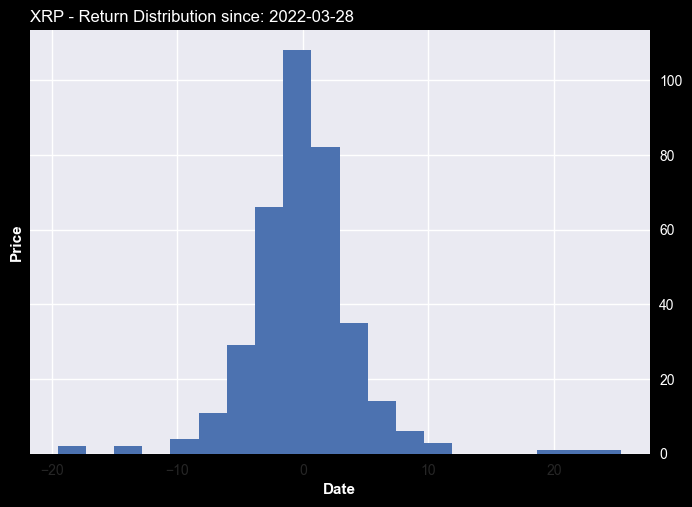

In [13]:
ticker = "xrp"
output = main(ticker,get_asset_data(ticker))

display(output[0][0], output[1], output[2], output[3], output[4], output[5], output[6], output[7])


Loading Daily data for AAPL with starting period 1990-01-02.

AAPL,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,Return_from0,TypicalPrice,SMA20,STD,Perc_change,SMA20_up,SMA20_down
date,,,,,,,,,,,,,,,
1990-01-02,0.250282,0.266257,0.248507,0.264482,0.264482,183198400,0.0,0.0,1.000000,0.259749,NaN,NaN,NaN,NaN,NaN
1990-01-03,0.269808,0.269808,0.266257,0.266257,0.266257,207995200,0.0,0.0,1.006711,0.267441,NaN,NaN,0.671088,NaN,NaN
1990-01-04,0.271583,0.275132,0.264482,0.267145,0.267145,221513600,0.0,0.0,1.010069,0.268920,NaN,NaN,0.333621,NaN,NaN
1990-01-05,0.268033,0.271583,0.262707,0.268033,0.268033,123312000,0.0,0.0,1.013425,0.267441,NaN,NaN,0.332232,NaN,NaN
1990-01-08,0.266257,0.269808,0.262707,0.269808,0.269808,101572800,0.0,0.0,1.020136,0.267441,NaN,NaN,0.662142,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-21,157.320007,159.399994,156.539993,159.279999,159.279999,73938300,0.0,0.0,602.233611,158.406662,151.1785,3.835076,1.194412,158.848652,143.508348
2023-03-22,159.300003,162.139999,157.809998,157.830002,157.830002,75701800,0.0,0.0,596.751210,159.260000,151.6245,4.068922,-0.910345,159.762345,143.486656
2023-03-23,158.830002,161.550003,157.679993,158.929993,158.929993,67622100,0.0,0.0,600.910247,159.386663,152.1010,4.343460,0.696947,160.787919,143.414081


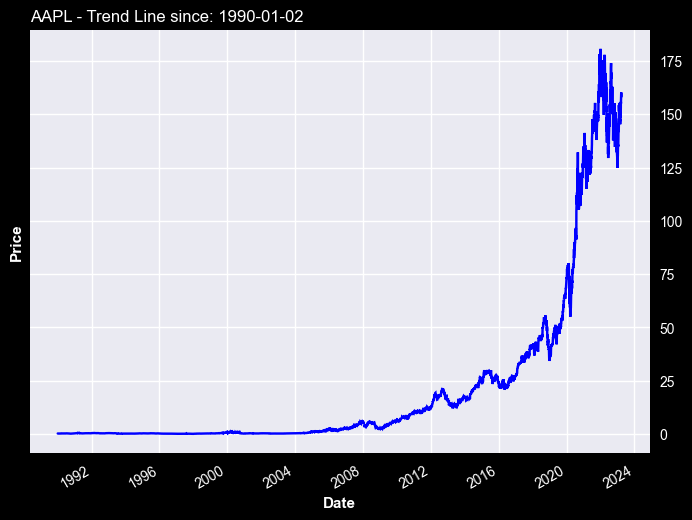

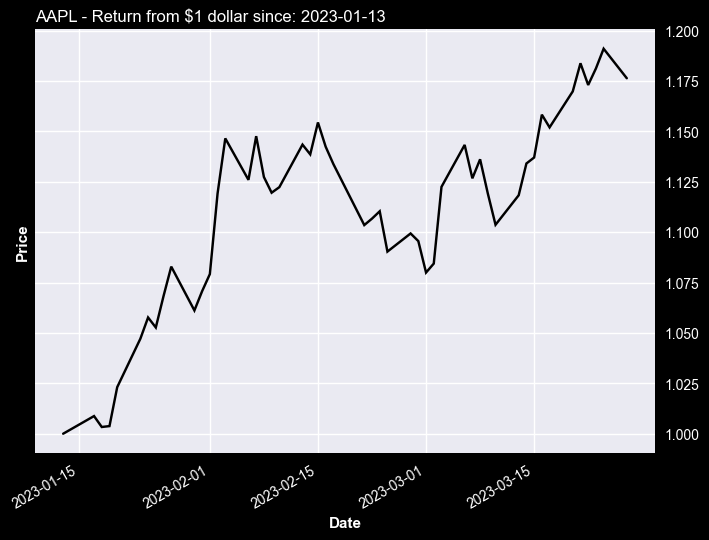

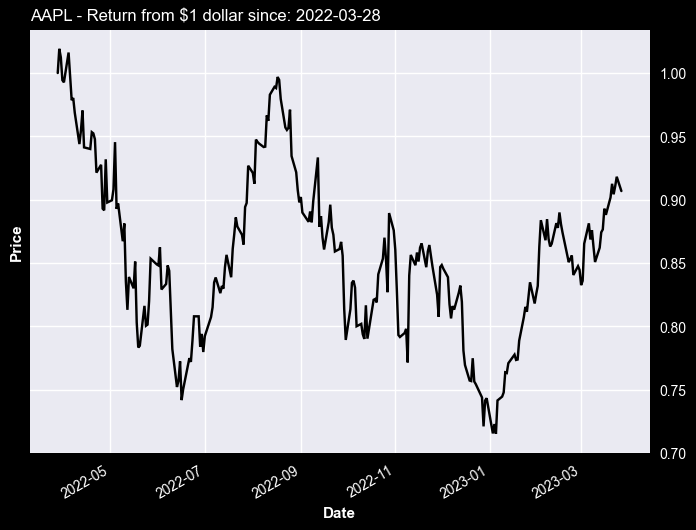

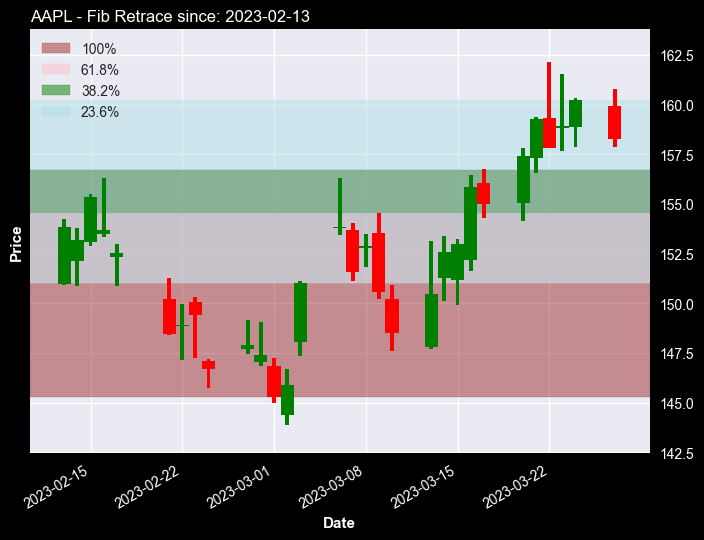

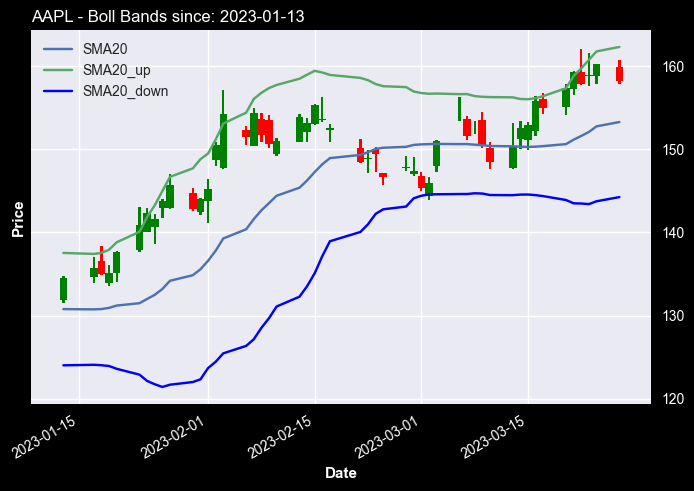

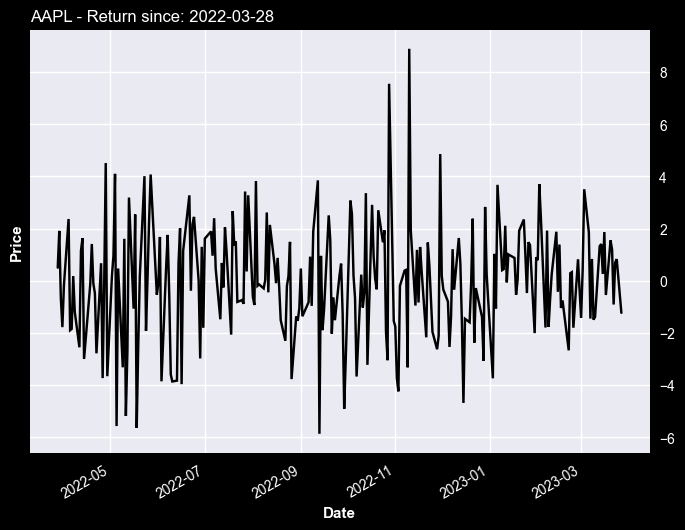

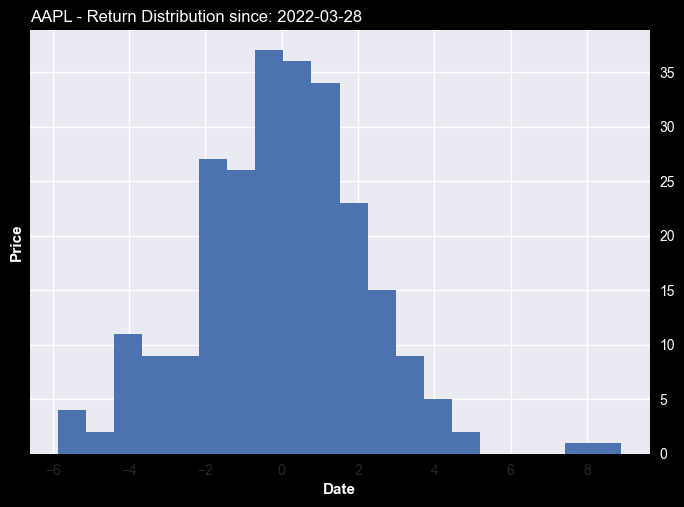

In [14]:
ticker = "aapl"
output = main(ticker,get_asset_data(ticker))

display(output[0][0], output[1], output[2], output[3], output[4], output[5], output[6], output[7])

# Run telegram bot

In Telegram:
Send "/start" to initiate 

In [ ]:
# Start command
@bot.message_handler(commands = ["start"])  
def start(message):
    bot.send_message(message.chat.id, "Hello, type 'help' for help", parse_mode = 'html')

# If any text is sent that is a ticker for crypto or stock it executes 
@bot.message_handler(content_types = "text")
def crypto_info(message):
    x = message.text.lower()
        
    help_message = "1. Type 'token list' to get a list of active tokens. \n2. Type 'stock list' to get a list of active stocks. \n\n3. To get asset info simply type the token ticker (ie 'aapl','meta', 'btc', 'eth')"
    if x == "help":
        bot.send_message(message.chat.id, help_message, parse_mode = 'html')
    if x == "token list":
        bot.send_message(message.chat.id, "List of Tokens:\n" + str(list_tokens()), parse_mode = 'html')
    if x == "stock list":
        bot.send_message(message.chat.id, "List of Stocks:\n" + str(list_stocks()[:500]), parse_mode = 'html')
        
    if x in list_tokens(): 
        data = main(x, get_asset_data(x))
        bot.send_message(message.chat.id, "Token: " + x.upper() + "\nCurrent Price: "+get_current_price(x), parse_mode = 'html')
        bot.send_message(message.chat.id, data[0][1].tail(5).to_string(), parse_mode = 'html')
        bot2.send_plot(data[1])
        bot2.send_plot(data[2])
        bot2.send_plot(data[3])
        bot2.send_plot(data[4])
        bot2.send_plot(data[5])
        bot2.send_plot(data[6])
        bot2.send_plot(data[7])

        
    if x in list_stocks(): 
        data = main(x, get_asset_data(x))
        bot.send_message(message.chat.id, "Stock: " + x.upper() + "\nCurrent Price: "+get_current_price(x), parse_mode = 'html')
        bot.send_message(message.chat.id, data[0][1].tail(5).to_string(), parse_mode = 'html')
        bot2.send_plot(data[1])
        bot2.send_plot(data[2])
        bot2.send_plot(data[3])
        bot2.send_plot(data[4])
        bot2.send_plot(data[5])
        bot2.send_plot(data[6])
        bot2.send_plot(data[7])
        
        
### Infinity polling wont turn off (keeps your computer running though, will timeout eventually however)
bot.infinity_polling()      

### Runs until web page times out 
# bot.polling()

# Other anaylsis 

In [15]:
# Compare multiple tokens
ticker_id = ["btc","eth","xrp","sol","atom","usdc","usdt","ray","usdr","ratio","sbr"]
# ticker_id = ["usdc","ray","usdr","ratio","sbr","sol"]
lst_df = []
close_lst = []
def get_data(lst):
    for i in lst:
        df = openbb.crypto.load(i, source = 'YahooFinance', exchange = 'binance')    
        df.columns.name = i.upper()
        df.columns = df.columns +"_"+i.upper()
        lst_df.append(df)
        close_lst.append(df["Close_"+i.upper()])
    return lst_df, close_lst
    
data = get_data(ticker_id)
close_data = pd.DataFrame(data[1]).T

# Returns over the last n days

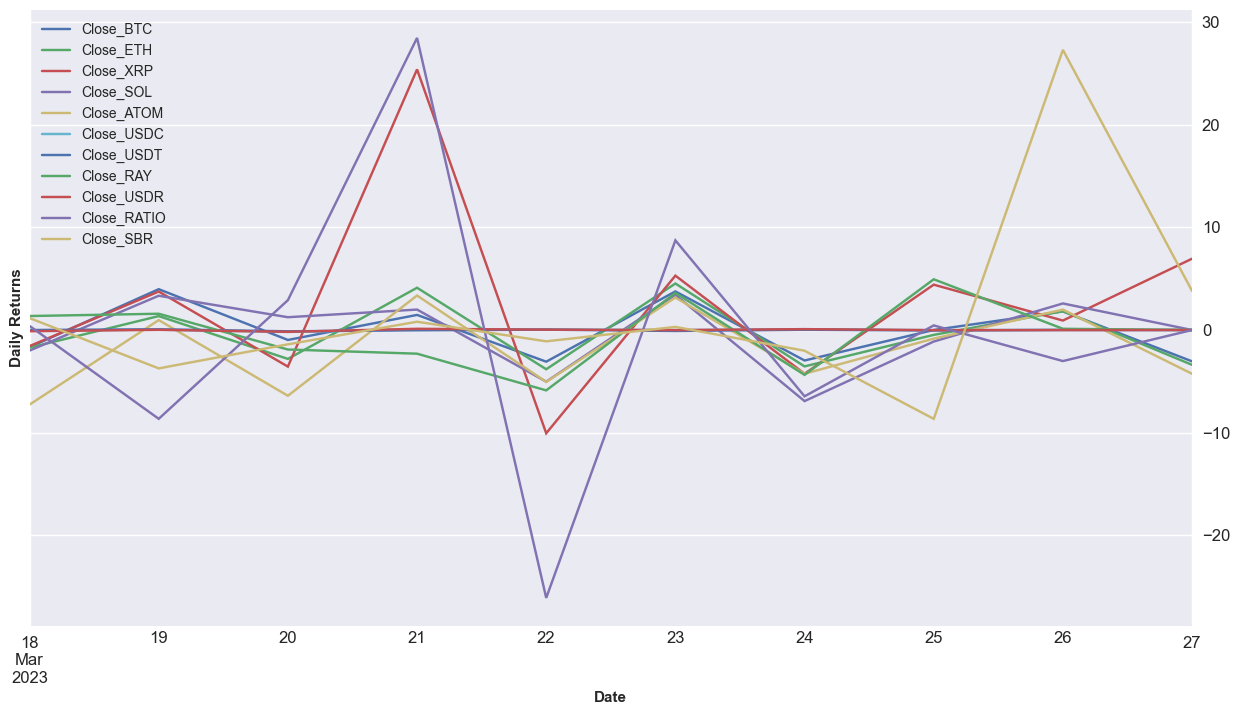

In [16]:
# Number of days
n_days = 10 # Change

# Get returns
close_data_pct_change = close_data.pct_change().mul(100)
# get the last (most recent) 10 day
close_data_pct_change = close_data_pct_change.iloc[-n_days:]

# Plot return over the last 10 days
close_data_pct_change.plot(figsize=(15,8), fontsize =12)

plt.legend(fontsize=12)
plt.legend(loc=2)
plt.ylabel("Daily Returns")
plt.xlabel("Date")

plt.show()

# Return for every dollar invest from n days ago

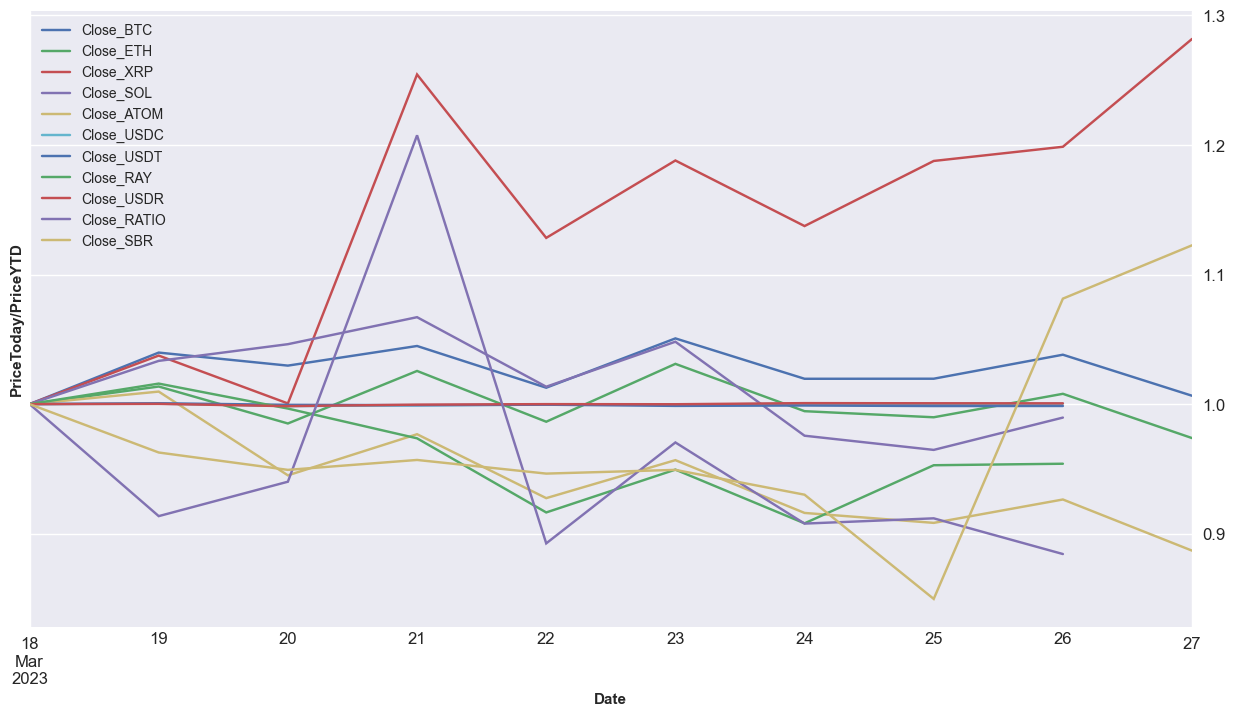

In [17]:
# Number of days
n_days = 10

close_data_return_dollar_n = close_data.iloc[-10:]

close_data_return_dollar_n = close_data_return_dollar_n.div(close_data_return_dollar_n.iloc[0])

close_data_return_dollar_n.plot(figsize=(15,8), fontsize =12)

plt.legend(fontsize=12)
plt.legend(loc=2)
plt.ylabel("PriceToday/PriceYTD")
plt.xlabel("Date")

plt.show()

# Return for every dollar invest from one year ago

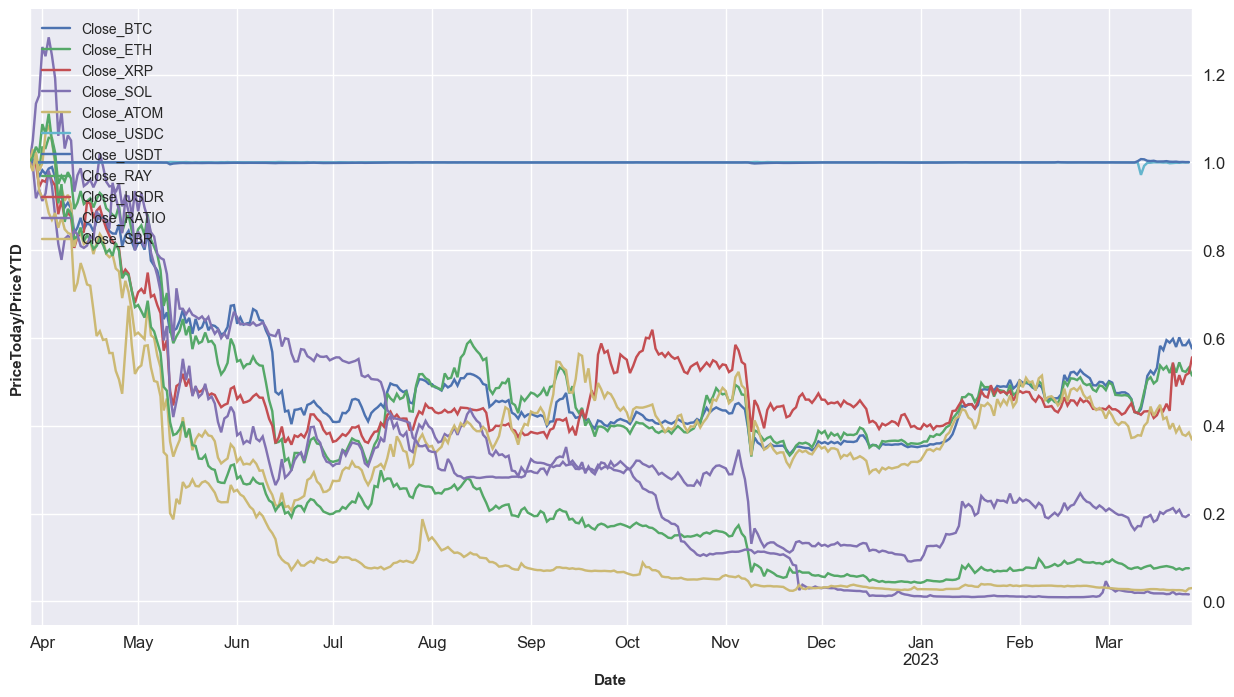

In [18]:
close_data_return_dollar_ytd = close_data

close_data_return_dollar_ytd = close_data_return_dollar_ytd.div(close_data_return_dollar_ytd.iloc[0])

close_data_return_dollar_ytd.plot(figsize=(15,8), fontsize =12)

plt.legend(fontsize=12)
plt.legend(loc=2)
plt.ylabel("PriceToday/PriceYTD")
plt.xlabel("Date")

plt.show()